# **Thư viện**

In [2]:
import pandas as pd
import numpy as np
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# **Dữ liệu**

In [3]:
data = pd.read_csv("../data/processed/EUR_VND_Exchange_Rate.csv", parse_dates=["Date"])
data.set_index("Date", inplace=True) 
data = data[["Sell"]].copy()
data.tail()

,Sell
Date,
2025-04-07,29106.52
2025-04-08,29215.21
2025-04-09,29443.52
2025-04-10,29178.76
2025-04-11,29775.69


# **Chuẩn hóa dữ liệu**

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)
df_scaled = pd.DataFrame(data_scaled, index=data.index, columns=["Sell"])

# **Chia Train/Test**

In [5]:
values = df_scaled["Sell"].values.astype(np.float32)
timestamps = df_scaled.index

train_size = int(len(values) * 0.8)
train_values, test_values = values[:train_size], values[train_size:]
train_timestamps, test_timestamps = timestamps[:train_size], timestamps[train_size:]

# --- TẠO SEQUENCES ---
seq_length = 30
def create_sequences(values, timestamps):
    X, y, y_timestamps = [], [], []
    for i in range(len(values) - seq_length):
        X.append(values[i : i + seq_length])
        y.append(values[i + seq_length])
        y_timestamps.append(timestamps[i + seq_length])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32), np.array(y_timestamps)

X_train, y_train, time_train = create_sequences(train_values, train_timestamps)
X_test, y_test, time_test = create_sequences(test_values, test_timestamps)


In [6]:
# Reshape input cho LSTM: (samples, time steps, features)
X_train = X_train.reshape(-1, seq_length, 1)
X_test = X_test.reshape(-1, seq_length, 1)

# **Mô hình LSTM**

In [34]:
def build_lstm_model(hp, seq_length):
    model = Sequential()
    model.add(Input(shape=(seq_length, 1)))
    model.add(LSTM(
        units=hp.Choice("lstm_units", [64, 96]),
        return_sequences=False,
        activation="tanh",
        kernel_regularizer=l2(hp.Choice("l2_reg", [0.001, 0.01]))
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Choice("dropout", [0.2, 0.3, 0.4])))
    model.add(Dense(hp.Choice("dense_units", [32, 64]), activation="relu"))
    model.add(Dense(1))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice("learning_rate", [0.001, 0.0005])),
        loss="mse",
        metrics=["mae"]
    )
    return model


In [35]:
# --- HUẤN LUYỆN MÔ HÌNH ---
def train_lstm(X_train, y_train, X_test, y_test, seq_length, model_path, project_name):
    tuner = kt.RandomSearch(
        lambda hp: build_lstm_model(hp, seq_length),
        objective="val_loss",
        max_trials=10,
        executions_per_trial=2,
        directory=r"C:\Users\DELL\Downloads\eur-vnd-exchange-rate\models",
        project_name=project_name
    )

    early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(model_path, save_best_only=True)

    tuner.search(X_train, y_train,
                 epochs=100,
                 batch_size=32,
                 validation_data=(X_test, y_test),
                 callbacks=[early_stopping, model_checkpoint])

    return tuner.get_best_hyperparameters(num_trials=1)[0]

In [36]:
import shutil
import os

tuner_dir = r"C:\Users\DELL\Downloads\eur-vnd-exchange-rate\models\LSTM"

if os.path.exists(tuner_dir):
    shutil.rmtree(tuner_dir)

In [37]:
best_hp = train_lstm(
    X_train, y_train,
    X_test, y_test,
    seq_length=30,
    model_path=r"D:\eur-vnd-exchange-rate\models\LSTM\best_lstm.h5",
    project_name="LSTM"
)

Trial 10 Complete [00h 02m 19s]
val_loss: 0.0005780297506134957

Best val_loss So Far: 0.0005780297506134957
Total elapsed time: 00h 14m 09s


In [38]:
best_hp.values

{'lstm_units': 64,
 'l2_reg': 0.01,
 'dropout': 0.4,
 'dense_units': 64,
 'learning_rate': 0.001}

# **Đánh giá mô hình**

In [8]:
best_model = load_model(r"D:\eur-vnd-exchange-rate\models\LSTM\best_lstm.h5", compile=False)
y_pred = best_model.predict(X_test).flatten()

# Inverse transform về giá gốc
y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
y_pred_actual = scaler.inverse_transform(y_pred.reshape(-1,1)).flatten()

# Metrics
mae = mean_absolute_error(y_test_actual, y_pred_actual)
mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test_actual, y_pred_actual) * 100

print("Đánh giá mô hình LSTM")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f}%")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Đánh giá mô hình LSTM
MAE: 84.8255
MSE: 16371.5596
RMSE: 127.9514
MAPE: 0.3037%


# **Thực tế và dự đoán**

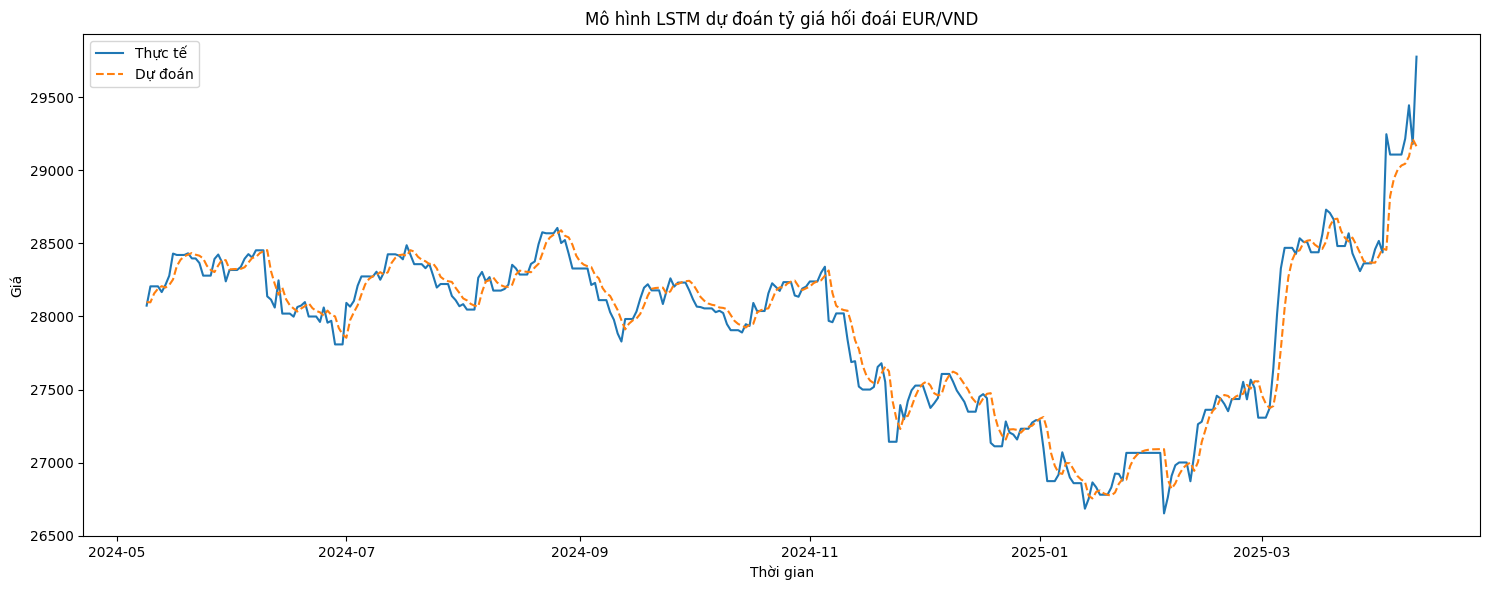

In [13]:
plt.figure(figsize=(15,6))
plt.plot(time_test, y_test_actual, label="Thực tế")
plt.plot(time_test, y_pred_actual, label="Dự đoán", linestyle="dashed")
plt.legend()
plt.title("Mô hình LSTM dự đoán tỷ giá hối đoái EUR/VND")
# plt.xticks(rotation=45)
plt.xlabel('Thời gian')
plt.ylabel('Giá')
plt.tight_layout()
plt.show()

In [16]:
from datetime import timedelta

# Lấy 30 ngày gần nhất làm input để dự đoán
last_sequence = df_scaled[-30:].values.reshape(1, 30, 1)

predictions_scaled = []
for _ in range(7):
    # Dự đoán 1 bước
    next_pred = best_model.predict(last_sequence)[0][0]
    predictions_scaled.append(next_pred)
    
    # Cập nhật sequence đầu vào
    new_seq = np.append(last_sequence[0, 1:, 0], next_pred)  # Bỏ phần tử đầu, thêm dự đoán mới
    last_sequence = new_seq.reshape(1, 30, 1)

# Đưa về giá gốc
predictions_actual = scaler.inverse_transform(np.array(predictions_scaled).reshape(-1, 1)).flatten()

# Tạo ngày tương ứng
last_date = df_scaled.index[-1]
next_dates = [last_date + timedelta(days=i) for i in range(1, 8)]

# Tạo bảng kết quả
forecast_df = pd.DataFrame({
    "Ngày": next_dates,
    "Giá dự đoán (EUR/VND)": predictions_actual
})
print(forecast_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
        Ngày  Giá dự đoán (EUR/VND)
0 2025-04-12           29385.074219
1 2025-04-13           29336.271484
2 2025-04-14           29287.789062
3 2025-04-15           29239.099609
4 2025-04-16           29191.281250
5 2025-04-17           29145.091797
6 2025-04-18           29100.980469
